<a href="https://colab.research.google.com/github/gurmaaan/MedNN/blob/master/Trained_CNN_no_changes_in_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Подключение Google диска

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
%cd /gdrive/My\ Drive/MedNN

In [1]:
#pytorch
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import models

# general
import os
from collections import defaultdict, Counter
import time
from datetime import datetime
import json
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd
from sklearn.metrics import accuracy_score
from pprint import pprint

## Загрузка данных 

In [2]:
#@title Параметры загрузчика

batch_size = 24  #@param {type: "slider", min: 4, max: 128}

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

resize_s = 256  #@param {type: "number"}
crop_s = 224  #@param {type: "number"}

train_path = "img/train" #@param ["img/train", "img/train_65", "img/train_enriched"] {allow-input: true}


In [3]:
def get_transforms(resize = 256, center_crop = 224):
    tr_dict = {
        'train': 
        [
            transforms.Resize(resize),
            transforms.CenterCrop(center_crop),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ],
        'valid': 
        [
            transforms.Resize(resize),
            transforms.CenterCrop(center_crop),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ],
        'test': 
        [
            transforms.Resize(resize),
            transforms.CenterCrop(center_crop),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]
    }
    return tr_dict

In [4]:
def update_data(path_dict, resize = 256, center_crop = 224, batch_size = 4):
    data_transforms = get_transforms(resize, center_crop)
    image_datasets = {x: ImageFolder(paths[x], transforms.Compose(data_transforms[x])) for x in paths}
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in paths}
    return data_transforms, image_datasets, dataloaders

In [5]:
paths = {
    "train" : train_path,
    "test" : "img/test",
    "valid" : "img/valid"
}

In [70]:
data_transforms, image_datasets, dataloaders = update_data(paths, resize_s, crop_s, batch_size)

In [75]:
a = [p for p in paths]

[71, 297, 65, 608, 3760, 632, 120, 80]

In [78]:
class_names = image_datasets['train'].classes
class_counts = defaultdict(list)
class_counts["class"] = class_names
for p in paths:
    class_counts[p] = list(Counter(image_datasets[p].targets).values())
pd.DataFrame(class_counts)

,class,train,test,valid
0,actinic keratosis,71,30,29
1,basal cell carcinoma,297,127,90
2,dermatofibroma,65,28,22
3,melanoma,608,303,202
4,nevus,3760,1673,1272
5,pigmented benign keratosis,632,259,208
6,squamous cell carcinoma,120,47,30
7,vascular lesion,80,37,25


In [103]:
weights = 1 / torch.Tensor(class_counts["train"])
weights_samples = torch.tensor([weights[t] for t in image_datasets["train"].targets])
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights_samples, len(weights_samples))
dataloaders["train"] = DataLoader(image_datasets["train"], batch_size=batch_size, num_workers=4, sampler=sampler)

In [104]:
for i, (inputs, labels) in enumerate(dataloaders["train"]):
    print(labels)
    if i > 20:
        break

tensor([3, 4, 4, 1, 4, 1, 2, 0, 7, 0, 7, 5, 0, 1, 2, 5, 2, 4, 6, 6, 4, 0, 4, 6])
tensor([5, 6, 7, 2, 7, 4, 3, 6, 0, 1, 2, 5, 2, 5, 4, 2, 0, 4, 5, 5, 3, 7, 4, 4])
tensor([1, 0, 4, 7, 6, 7, 3, 7, 0, 5, 3, 5, 7, 5, 0, 0, 3, 6, 4, 4, 2, 1, 0, 0])
tensor([7, 3, 1, 6, 7, 6, 2, 4, 3, 7, 4, 7, 2, 6, 1, 2, 0, 6, 4, 4, 1, 0, 7, 0])
tensor([4, 2, 5, 7, 5, 5, 2, 4, 0, 4, 0, 0, 1, 3, 2, 6, 7, 5, 2, 2, 0, 0, 0, 1])
tensor([3, 1, 2, 0, 3, 7, 6, 6, 0, 1, 2, 4, 2, 3, 4, 0, 1, 3, 6, 7, 0, 5, 3, 2])
tensor([4, 0, 0, 3, 6, 2, 0, 7, 7, 0, 5, 4, 0, 4, 7, 4, 2, 3, 4, 5, 0, 4, 0, 4])
tensor([6, 0, 2, 3, 3, 5, 6, 4, 2, 2, 4, 5, 0, 2, 7, 5, 3, 4, 7, 0, 6, 0, 7, 6])
tensor([4, 4, 3, 4, 0, 5, 0, 5, 1, 7, 7, 3, 5, 3, 0, 3, 6, 4, 3, 2, 0, 7, 0, 6])
tensor([1, 6, 2, 5, 0, 7, 0, 3, 6, 4, 4, 0, 5, 0, 6, 2, 4, 4, 4, 4, 0, 3, 0, 3])
tensor([7, 4, 6, 2, 4, 4, 3, 0, 0, 7, 2, 2, 5, 3, 0, 2, 4, 6, 7, 3, 7, 1, 1, 1])
tensor([6, 3, 2, 7, 7, 0, 2, 0, 7, 0, 7, 5, 5, 0, 2, 4, 6, 7, 5, 7, 1, 7, 4, 1])
tensor([7, 6, 3, 2, 7, 7, 0,

In [13]:
dataset_sizes = {x: len(image_datasets[x]) for x in paths}
pprint(dataset_sizes)
for p in dataset_sizes:
    if dataset_sizes[p] % batch_size == 1:
        print(f"Incorrect bath_size. {p} size % batch_size = {dataset_sizes[p]} % {batch_size} == 1")

{'test': 2504, 'train': 5633, 'valid': 1878}


## Device

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
else:
    print("CPU device")

GeForce GTX 970


## Визуализация 

In [16]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    
    #revert normalization
    inp = std * inp + mean
    
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(16, 16))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

In [ ]:
imgs, labels = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(imgs)

imshow(out, title=[class_names[x] for x in labels])

## Функция обучения


In [17]:
def train_model(model, criterion, optimizer, scheduler = None, num_epochs=25):
    start_time = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    stat_dict = {
        "train" :{ "epoch" : [], "loss" : [], "acc" : [] },
        "valid" :{ "epoch" : [], "loss" : [], "acc" : [] }
    }
    expect = 0
    print(f"Начало обучения. Проход в {num_epochs} эпох.")
    for epoch in range(num_epochs):
        estart_time = time.time()
        # У каждой эпохи есть фаза обучения и фаза валидации 
        for phase in ["train", "valid"]:
            is_train_phase = (phase == "train")
            # Ставим модель в нужный режим в зависимости от фазы 
            model.train(is_train_phase)
            running_loss = 0.0
            running_corrects = 0
            
            # Проходим по датасету партиями размером с батч
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # Обнуляем градиенты вычесленные на предыдущем батче, иначе они будут складываться один за другим 
                optimizer.zero_grad()
                # Прямой проход Общая для обучения и валидации. 
                # Если фаза обучения, то все градиенты (частные производные функции потерь) 
                # будут вычислены чтобы вычесть их из текущих весов. Если валидация - вычисляться не будут
                with torch.set_grad_enabled(is_train_phase):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # Реализация обратного распространения ошибки 
                    if is_train_phase:
                        # Рассчет всех частных производных dloss_dw1(w1_0). Внутри батча усредняются
                        loss.backward()
                        # Обновление весов (w1_1 = w1_0 - lr * dloss_dw1(w1_0) и так далее
                        optimizer.step() 

                # Расчет точности и потери на конкретной эпохе 
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if is_train_phase and (scheduler is not None):
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            # Сохраняем веса если точность выше чем была
            if (not is_train_phase) and (epoch_acc > best_acc):
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            stat_dict[phase]["epoch"].append(epoch)
            stat_dict[phase]["loss"].append(epoch_loss)
            stat_dict[phase]["acc"].append(epoch_acc.item())
            
            te = time.time() - estart_time
            if epoch == 0:
                expect += te
                if not is_train_phase:
                    expect *= (num_epochs - 1) * 0.6
                    print(f"{datetime.now():%Y-%m-%d %H:%M}. Приблизительное оставшееся время {expect//60:2.0f}м {expect%60:2.0f}с")
                    print("***")
            if ( (epoch+1) % 5 == 0 ) and epoch != 0:        
                print(f"{epoch+1:2}. {phase}. loss: {epoch_loss:.4f}. acc: {epoch_acc:.4f}. time {te//60:2.0f}м {te%60:2.0f}с")

    print('-'*80)
    time_elapsed = time.time() - start_time
    print(f"Обучение закончено. Общее время: {time_elapsed//60:2.0f}м {time_elapsed%60:2.0f}с")
    print(f"valid acc: {best_acc * 100 :.2f}%")

    # Возвращается модель с лучшими весами 
    model.load_state_dict(best_model_wts)
    return model, stat_dict

## Функция тестирования

In [18]:
def test_model(model, print_log=True):
    result_dict = { "real" : [], "predicted" : [] }

    with torch.no_grad():
        for images, labels in dataloaders["test"]:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            for i in range(len(labels)):
                result_dict["real"].append(class_names[labels[i]])
                result_dict["predicted"].append(class_names[predicted[i]])

    result_df = pd.DataFrame(result_dict)

    acc_dict = {}
    total_acc = accuracy_score(result_df["real"], result_df["predicted"]) * 100
    acc_dict["total"] = total_acc

    for img_class in class_names:
        class_df = result_df[result_df["real"] == img_class]
        class_acc = accuracy_score(class_df["real"], class_df["predicted"]) * 100
        acc_dict[img_class] = class_acc
        if print_log:
            print(f"{img_class} ({len(class_df)}) : {class_acc :.2f}%")

    print(f"test acc: {total_acc :.2f}%")
    
    return acc_dict

## Вспомогательные функции 

In [19]:
def convert_score_to_df(score_dict, save_flag=True, save_path = "/nn", save_dir="", single_model=False):
    data = defaultdict(list)
    if len(score_dict.keys()) > 0:
        first_model_name = list(score_dict.keys())[0]
        for scope in score_dict[first_model_name]:
            data["scope"].append(scope)
            for model_name in score_dict:
                data[model_name].append(f"{score_dict[model_name][scope] : .2f}")
        
        df = pd.DataFrame(data)
        df = df.set_index("scope")
        
        if save_flag:
            output_dir = f"{save_path}/{save_dir}"
            if not os.path.isdir(output_dir):
                os.makedirs(output_dir)
            file_name = f"{first_model_name}_score.csv" if single_model else "models_score.csv"

            df.to_csv(f"{output_dir}/{file_name}", sep=';')
    else:
        df  = pd.DataFrame()
    return df

In [20]:
def save_learning_stat(loss_dict, save_path = "/nn", save_dir="", modelname="NN"):
    output_dir = f"{save_path}/{save_dir}"
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
    with open(f"{output_dir}/{modelname}.json", 'w') as json_file:
        json.dump(loss_dict, json_file)

In [21]:
def plot_learning_curve(data, model_name, save_flag=True, save_path = "/nn", save_dir=""):
    # data = json.load(open(path_json, 'r'))
    
    epochs = data["train"]["epoch"]
    
    fig, axs = plt.subplots(2, figsize=(16,12))
    # model_name = path.split('/')[-1].split('.')[0]
    fig.suptitle(model_name)
    
    epcnt = float(epochs[-1])
    step = 1
    while epcnt / step >= 20:
        step += 1

    for i, mode in enumerate(["loss", "acc"]):
        for phase in ["train", "valid"]:
            axs[i].set_title(mode)
            axs[i].plot(epochs, data[phase][mode], label=phase)
            axs[i].set_xlabel("Эпохи")
            axs[i].legend(loc=1)
            axs[i].grid(True)
            delta = 0.001
            axs[i].set_xlim(xmin=(0 - delta), xmax=(epcnt + delta))
            axs[i].set_xticks([xt for xt in range(0, int(epcnt+1), step)])

    if save_flag:
        output_dir = f"{save_path}/{save_dir}"
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)
        save_learning_stat(data, save_path, save_dir, model_name)
        plt.savefig(f"{output_dir}/{model_name}.png")

## Параметры 

In [187]:
#@title Параметры обучения

save_path = "C:/Users/Dima/YandexDisk/EDUCATION/_Deeplom/nn" #@param {type: "string"}
save_dir = "default_diffep" #@param {type: "string"}
#@markdown ---
num_epochs = 24 #@param {type:"slider", min:3, max:45, step:3}
#@markdown ---
start_lr = 0.01  #@param {type: "number"}
use_lr_scheduler = True #@param {type:"boolean"}
lr_scheduler_step = 7 #@param {type:"integer"}

## **ОБУЧЕНИЕ**

In [43]:
data_transforms, image_datasets, dataloaders = update_data(paths, resize_s, crop_s, batch_size)

In [112]:
model_dict = {
#     "ResNeXt_50_32x4d": {"model" : models.resnext50_32x4d(pretrained=True), "type" : "fc", "epochs" : num_epochs, "lr_step" : lr_scheduler_step},
#     "MnasNet_0-5" : {"model" : models.mnasnet0_5(pretrained=True), "type" : "cl", "epochs" : num_epochs, "lr_step" : lr_scheduler_step},
#     "Wide_ResNet_50-2" : {"model" : models.wide_resnet50_2(pretrained=True), "type" : "fc", "epochs" : num_epochs, "lr_step" : lr_scheduler_step}
#     "VGG_13" : {"model" : models.vgg13(pretrained=True), "type" : "cl", "epochs" : num_epochs, "lr_step" : lr_scheduler_step}
#   ------------
#     "AlexNet" : {"model" : models.alexnet(pretrained=True), "type" : "cl", "epochs" :int(num_epochs/2), "lr_step" : int(lr_scheduler_step / 2)},
    "MobileNet_v2" : {"model" : models.mobilenet_v2(pretrained=True), "type" : "cl", "epochs" : int(num_epochs/2), "lr_step" : int(lr_scheduler_step / 2)},
    "ResNet_152" : {"model" : models.resnet152(pretrained=True), "type" : "fc", "epochs" : int(num_epochs/2), "lr_step" : int(lr_scheduler_step / 2)},
    "ResNeXt_101_32x8d" : {"model" : models.resnext101_32x8d(pretrained=True), "type" : "fc", "epochs" : int(num_epochs/2), "lr_step" : int(lr_scheduler_step / 2)},
#     "Wide_ResNet_101-2" : {"model" : models.wide_resnet101_2(pretrained=True), "type" : "fc", "epochs" : int(num_epochs/3), "lr_step" : int(lr_scheduler_step / 2)},
#   ------------
#     "VGG_19_bn" : {"model" : models.vgg19_bn(pretrained=True), "type" : "cl", "epochs" : num_epochs*2, "lr_step" : lr_scheduler_step * 2},
#     "MnasNet_1-0" : {"model" : models.mnasnet1_0(pretrained=True), "type" : "cl", "epochs" : num_epochs*2, "lr_step" : lr_scheduler_step * 2},
#     "Inception_v3" : {"model" : models.inception_v3(pretrained=True), "type" : "fc", "epochs" : num_epochs*2, "lr_step" : lr_scheduler_step * 2}
}

In [113]:
def learn_model(model, model_name, params_to_learn, ep_num, lr_step):
    mnl = int(len(model_name) / 2)
    print(' ' * (40 - mnl), model_name, ' ' * (40 - mnl))
    print('_'*80)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(params_to_learn, lr=start_lr, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_step, gamma=0.1) if use_lr_scheduler else None

    model, learning_dict = train_model(model, criterion, optimizer, exp_lr_scheduler, ep_num)
    
    plot_learning_curve(learning_dict, model_name, True, save_path, save_dir)
    
    coeff_path = f"{save_path}/{save_dir}/{model_name}.pth"
    torch.save(model.state_dict(), coeff_path)
    model_dict[model_name]["model"] = model

    score = test_model(model, False)
    return convert_score_to_df({model_name : score}, True, save_path, save_dir, True)

In [ ]:
print('_'*80)
for model_name in model_dict:
    model = model_dict[model_name]["model"]
    
    if model_name == "Inception_v3":
        data_transforms, image_datasets, dataloaders = update_data(paths, resize=340, center_crop=299, batch_size = batch_size)
        model.aux_logits=False

    # Указываем парамтры модели для которых не требуется строить граф вычислений градиента. <=> "замораживаем веса"
    for param in model.parameters():
        param.requires_grad = False

    params_to_learn = model.parameters()

    # Последний слой модели меняется на собственный полносвязный
    if model_dict[model_name]["type"] == "fc":
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, len(class_names))
        params_to_learn = model.fc.parameters()
    else:
        num_ftrs = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_ftrs, len(class_names))
        params_to_learn = model.classifier[-1].parameters()
    # Запуск процесса обновления весов
    try:
        learn_model(model, model_name, params_to_learn, model_dict[model_name]["epochs"], model_dict[model_name]["lr_step"])
    except Exception as e:
        print(f"{model_name} failed. {str(e)}")
    print('_'*80)

## Объединение результатов 

In [188]:
def collect_stat(root=None):
    if (root is not None) and os.path.isdir(root):
        data = {}
        for file_name in os.listdir(root):
            if file_name.split('.')[-1] == "csv":
                df = pd.read_csv(os.path.join(root, file_name), sep=';')
                df = df.set_index(df.columns[0])
#                 df = df.sort_values(by=[df.columns[0]])
                
                for col in df.columns:
                    data[col] = df[col]
        
        return pd.DataFrame(data)
    else:
        return pd.DataFrame()

In [190]:
collect_stat(f"{save_path}/{save_dir}/")[["ResNeXt_101_32x8d","ResNet_152",  "MobileNet_v2"]]

,ResNeXt_101_32x8d,ResNet_152,MobileNet_v2
scope,,,
total,80.27,79.43,78.47
actinic keratosis,43.33,53.33,50.00
basal cell carcinoma,70.08,61.42,62.99
dermatofibroma,39.29,17.86,7.14
melanoma,52.15,37.29,42.24
nevus,92.89,94.68,92.35
pigmented benign keratosis,57.14,60.23,60.62
squamous cell carcinoma,31.91,19.15,23.40
vascular lesion,59.46,75.68,72.97


## Точность ансамбля

In [191]:
model_names = ["ResNeXt_101_32x8d","ResNet_152",  "MobileNet_v2"]
answers = {m_name : defaultdict(list) for m_name in model_names}
answers["real"] = defaultdict(list)
answers["predicted"] = defaultdict(list)

In [192]:
# ma_p - вероятность ответа выданного моделью (для действительного ответа вероятность равна 1)
with torch.no_grad():
    for images, labels in dataloaders["test"]:
        images, labels = images.to(device), labels.to(device)
        for l in labels:
            answers["real"]["lbls"].append(l.item())
        for m_name in ans_models:
            model = model_dict[m_name]["model"]
            
            if model_dict[m_name]["type"] == "fc":
                model.fc = nn.Linear(model.fc.in_features, len(class_names))
            else:
                model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, len(class_names))
            
            model.load_state_dict( torch.load(f"{save_path}/{save_dir}/{m_name}.pth") )
            
            model = model.to(device)
            
            outputs = model(images)
#             https://pytorch.org/docs/stable/torch.html#torch.max, вторая часть с keepdim
            _, pred_lbls = torch.max(outputs.data, dim=1)
            pred_probas, _ = torch.max(torch.nn.functional.softmax(outputs, dim=1), dim=1)
            for i, _ in enumerate(labels):
                answers[m_name]["lbls"].append(pred_lbls[i].item())
                answers[m_name]["ma_p"].append(pred_probas[i].item())
                
# cl_p - вероятность встретить класс в тестовой выборке
total = len(image_datasets["test"].targets)
cntr = Counter(image_datasets["test"].targets)
cl_p = {}
for cl in cntr:
    cl_p[cl] = cntr[cl] / total
print(cl_p)

# m_p - вероятность того что модель даст правильный ответ 
m_p = {}
for m_name in model_names:
    m_p[m_name] = collect_stat(f"{save_path}/{save_dir}/").iloc[0][m_name] / 100 
print(m_p)

{0: 0.011980830670926517, 1: 0.05071884984025559, 2: 0.011182108626198083, 3: 0.12100638977635783, 4: 0.6681309904153354, 5: 0.10343450479233227, 6: 0.018769968051118212, 7: 0.014776357827476038}
{'ResNeXt_101_32x8d': 0.8027, 'ResNet_152': 0.7943000000000001, 'MobileNet_v2': 0.7847}


In [197]:
for m_name in model_names:
    answers[m_name]["probas"] = []
    answers["predicted"]["lbls"] = []

for i, ra in enumerate(answers["real"]["lbls"]):
    pred_lbls = []
    for m_name in model_names:
        pred_lbls.append(answers[m_name]["lbls"][i])
    
    counter = Counter(pred_lbls)
    a_p = {}
    for cl in counter:
        a_p[cl] = counter[cl] / len(pred_lbls)
    
    max_prob = 0
    pred = 0
    for m_name in model_names:
        ma = answers[m_name]["lbls"][i] 
        ma_prob = answers[m_name]["ma_p"][i]
        ma_prob *= m_p[m_name] * a_p[ma]
        answers[m_name]["probas"].append(ma_prob)
        if ma_prob > max_prob:
            max_prob = ma_prob
            pred = ma
    answers["predicted"]["lbls"].append(pred)
    
prob_dict = {}
for an in answers:
    if "probas" in answers[an]:
        prob_dict[f"new_{an}"] = answers[an]["probas"]
        prob_dict[f"{an}"] = answers[an]["ma_p"]
        prob_dict[f"ans_{an}"] = answers[an]["lbls"]
prob_dict["real"] = answers["real"]["lbls"]
prob_dict["pred"] = answers["predicted"]["lbls"]
ans_df = pd.DataFrame(prob_dict)
ans_df.head(10)

,new_ResNeXt_101_32x8d,ResNeXt_101_32x8d,ans_ResNeXt_101_32x8d,new_ResNet_152,ResNet_152,ans_ResNet_152,new_MobileNet_v2,MobileNet_v2,ans_MobileNet_v2,real,pred
0,0.771459,0.961080,4,0.736446,0.927163,4,0.783043,0.997889,4,4,4
1,0.802667,0.999959,4,0.794116,0.999768,4,0.783871,0.998943,4,4,4
2,0.799852,0.996452,5,0.575674,0.724757,5,0.780699,0.994901,5,5,5
3,0.744445,0.927426,4,0.793531,0.999032,4,0.784309,0.999502,4,4,4
4,0.412126,0.770137,4,0.223751,0.845087,3,0.510773,0.976372,4,4,4
5,0.410473,0.767049,5,0.180260,0.680825,3,0.502465,0.960491,5,5,5
6,0.699887,0.871916,4,0.793102,0.998492,4,0.781509,0.995933,4,4,4
7,0.790985,0.985405,4,0.704010,0.886328,4,0.781736,0.996223,4,4,4
8,0.533593,0.997121,4,0.526934,0.995091,4,0.170939,0.653518,2,4,4
9,0.802684,0.999980,4,0.788771,0.993039,4,0.784694,0.999993,4,4,4


In [198]:
accs = []
classes = ['total']
total_acc = accuracy_score(ans_df["real"], ans_df["pred"]) * 100
accs.append(f"{total_acc :.2f}")

for cl in ans_df["real"].unique():
    tmp = ans_df[ans_df["real"] == cl]
    acc = accuracy_score(tmp["real"], tmp["pred"]) * 100
    accs.append(f"{acc :.2f}")
    classes.append(class_names[cl])
    
pd.DataFrame({"scope" : classes, "ensemble" : accs})

,scope,ensemble
0,total,78.99
1,nevus,89.90
2,pigmented benign keratosis,58.69
3,melanoma,53.80
4,vascular lesion,86.49
5,basal cell carcinoma,66.93
6,squamous cell carcinoma,38.30
7,actinic keratosis,53.33
8,dermatofibroma,28.57


## Все графики на одном

In [27]:
def single_plot(ax, data, m_name, mode, step):
    epochs = data["train"]["epoch"]
    epcnt = float(epochs[-1])
    for phase in ["train", "valid"]:
#         clr = "green" if phase == "valid" else "blue"
#         clr = "light" + clr if mode == "acc" else clr
        ax.set_title(f"{m_name}", fontsize=12)
        ax.plot(epochs, data[phase][mode], label=phase)
        ax.set_ylabel(f"{mode}")
        ax.legend(loc=1)
        ax.grid(True)
        delta = 0.001
        ax.set_xlim(left=(0 - delta), right=(epcnt + delta))
        ax.set_xticks([xt for xt in range(0, int(epcnt+2), step)])

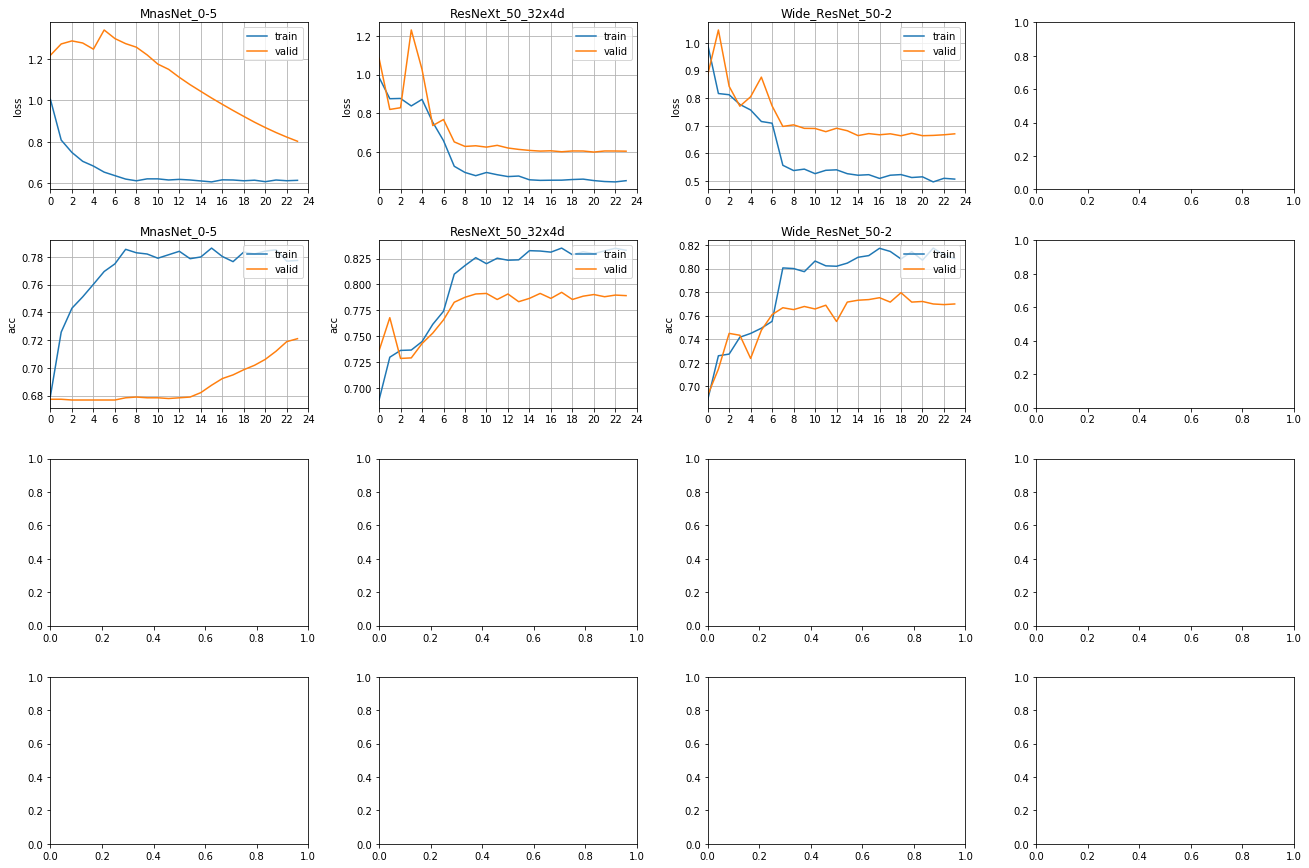

In [28]:
fig, axs = plt.subplots(4,4, figsize=(18,12))
fig.tight_layout(h_pad=3, w_pad = 4)
i = 0
for file_name in os.listdir(f"{save_path}/{save_dir}/"):
    if file_name.split('.')[-1] == "json":
        path_json = f"{save_path}/{save_dir}/{file_name}"
        data = json.load(open(path_json, 'r'))
        model_name = file_name.split('.')[0]
        pad = 0 if i < 4 else 1
        single_plot(axs[int(i / 4) + pad][i % 4], data, model_name, "loss", 2)
        single_plot(axs[int(i / 4) + pad+1][i % 4], data, model_name, "acc", 2)
        i+=1
plt.savefig("default_24ep.png", dpi=300)

## Предсказание

In [ ]:
def predict(img_path=None, model_name="inception_v3", path="/nn/default/inception_v3.pth"):
    if os.path.isfile(img_path) and (model_name in model_dict) and os.path.isfile(img_path):
        img = Image.open(img_path)
        model = model_dict[model_name]
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 8)
        model.load_state_dict(torch.load(path))
        model.eval()
        
        img_input = transforms.Compose(data_transforms["test"])(img)
        img_input = img_input.unsqueeze(0)
        with torch.no_grad():
            output = model(img_input)
            _, predicted = torch.max(output.data, 1)
            proba = torch.nn.functional.softmax(output, dim=1).tolist()[0]
            
            plt.barh(class_names, proba, align="center")
            plt.xlim(0, 1)
            plt.xticks(np.arange(0, 1, 0.1))
            plt.grid(True, axis="x")
            
            for i, p in enumerate(proba):
                print(f"{p : .10f} - {class_names[i]}")
                plt.text(p, i, f"{p : .10f}")
        return class_names[predicted[0]]
    else:
        return None